# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [ ]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [1]:
# Import essential libraries
import numpy  as np
import os
import pandas as pd
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

Load the dataset.

In [2]:
# Load and unzip the dataset
!unzip /content/sample_data/data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/Glass/file_96.png  
  inflating: data/Paper/file_560.png  
  inflating: data/Glass/file_620.png  
  inflating: data/Glass/file_676.png  
  inflating: data/Glass/file_177.png  
  inflating: data/Glass/file_749.png  
  inflating: data/Glass/file_460.png  
  inflating: data/Glass/file_127.png  
  inflating: data/Glass/file_438.png  
  inflating: data/Glass/file_132.png  
  inflating: data/Glass/file_98.png  
  inflating: data/Glass/file_427.png  
  inflating: data/Glass/file_351.png  
  inflating: data/Glass/file_74.png  
  inflating: data/Glass/file_377.png  
  inflating: data/Glass/file_445.png  
  inflating: data/Glass/file_229.png  
  inflating: data/Glass/file_658.png  
  inflating: data/Glass/file_627.png  
  inflating: data/Glass/file_53.png  
  inflating: data/Glass/file_420.png  
  inflating: data/Glass/file_740.png  
  inflating: data/Glass/file_458.png  
  inflating: data/Glass/file_519.png  
  inflating: data

## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [3]:
# Create a function to load the raw images

import pathlib
data = '/content/data'
data_dir = pathlib.Path(data).with_suffix('')
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)
# Cardboard = list(data_dir.glob('Cardboard/*'))
# PIL.Image.open(str(Cardboard[0]))

list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

7625


#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [4]:
# Get the images and their labels
class_names = np.array([item.name for item in data_dir.glob('*')])
print(class_names)

def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  label = parts[-2] == class_names
  return tf.argmax(label)

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_png(img, channels=3)
  return img


def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

['Cardboard' 'Glass' 'Metal' 'Paper' 'Other' 'Plastic' 'Food_Waste']


In [5]:
list_ds_old = list_ds
list_ds = list_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

In [6]:
# Visualise Data Distribution
class_paths = [item for item in data_dir.glob('*')]
class_dict = {class_path.name:len(list(class_path.glob('*'))) for class_path in class_paths}
class_dict

# x and y values
categories = list(class_dict.keys())
values = list(class_dict.values())

# Create plot
plt.figure(figsize=(8,3))
plt.bar(categories,values,color='blue')

# Add labels and Title
plt.xlabel('Waste Type', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.title('Waste Material by Type', fontsize=14, fontweight='bold')

plt.show()

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

In [7]:
# Visualise Sample Images (across different labels)
i=0
plt.figure(figsize=(10, 10))
for image, label in list_ds.take(9):
    i+= 1
    ax = plt.subplot(3, 3, i)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[label])
    plt.axis('off')

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [8]:
# Find the smallest and largest image dimensions from the data set
images = list(data_dir.glob('*/*.png'))
sizes = [PIL.Image.open(image).size for image in images]
max_size = max(sizes)
min_size = min(sizes)
print(max_size , min_size)

(256, 256) (256, 256)


In [10]:
# Resize the image dimensions

def decode_img_model(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_png(img, channels=3)
  img = tf.image.resize(img, [180, 180])
  return img

### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [12]:
# Encode the labels suitably
def get_label_model(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  label = parts[-2] == class_names
  return tf.argmax(label)

In [13]:
# Get Image and label
def process_path_model(file_path):
  label = get_label_model(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img_model(img)
  return img, label

### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [14]:
# Assign specified parts of the dataset to train and validation sets

val_size = int(image_count * 0.3)
train_ds = list_ds_old.skip(val_size)
val_ds = list_ds_old.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

# Convert file path to image, label pair
train_ds = train_ds.map(process_path_model, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.map(process_path_model, num_parallel_calls=tf.data.experimental.AUTOTUNE)

5338
2287


In [15]:
# Configure dataset for perfromance
batch_size = 32
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [16]:
# Display the image dimensions
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [17]:
# Build and compile the model
num_classes = len(class_names)
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(180,180,3)),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,658,823 (6.33 MB)

 Trainable params: 1,658,823 (6.33 MB)

 Non-trainable params: 0 (0.00 B)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [20]:
# Training
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

Epoch 1/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6014 - loss: 1.1025 - val_accuracy: 0.5011 - val_loss: 1.4744
Epoch 2/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7010 - loss: 0.8570 - val_accuracy: 0.5400 - val_loss: 1.4591
Epoch 3/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7945 - loss: 0.5942 - val_accuracy: 0.5549 - val_loss: 1.6323
Epoch 4/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8745 - loss: 0.3732 - val_accuracy: 0.5658 - val_loss: 2.0065
Epoch 5/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9128 - loss: 0.2619 - val_accuracy: 0.5409 - val_loss: 2.0483


In [28]:
# Modify model to add mormalization and dropout layers to improve validation accuracy
# Add more input layers
num_classes = len(class_names)
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(180,180,3)),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.50),

  tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 87, 87, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 87, 87, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 41, 41, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 41, 41, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       819,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 839,751 (3.20 MB)

 Trainable params: 839,431 (3.20 MB)

 Non-trainable params: 320 (1.25 KB)

In [30]:
# Retraining
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - accuracy: 0.2610 - loss: 2.2802 - val_accuracy: 0.1631 - val_loss: 4.8046
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.4049 - loss: 1.7339 - val_accuracy: 0.2973 - val_loss: 3.3320
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.4374 - loss: 1.5603 - val_accuracy: 0.2287 - val_loss: 8.4579
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.4334 - loss: 1.5888 - val_accuracy: 0.2812 - val_loss: 1.9507
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.4767 - loss: 1.4351 - val_accuracy: 0.2304 - val_loss: 2.4633
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5383 - loss: 1.2919 - val_accuracy: 0.2912 - val_loss: 2.3372
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.5703 - loss: 1.1834 - val_accuracy: 0.4263 - val_loss: 2.3422
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.6107 - loss: 1.1026 - val_ac

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [ ]:
# Evaluate on the test set; display suitable metrics
result_dict = model.evaluate(val_ds,verbose=0, return_dict=True)



In [ ]:
for metric_name, value in result_dict.items():
    print(f"{metric_name}: {value:.4f}")

accuracy: 0.5282
loss: 1.3998


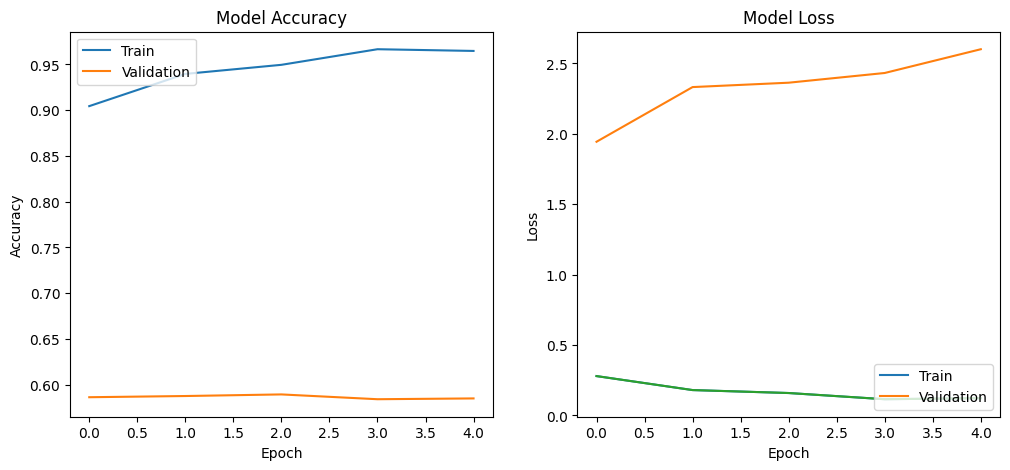

In [25]:
plt.figure(figsize=(12, 5))
# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.plot(history.history['loss'])

plt.show()

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [ ]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [ ]:
# Create a function to augment the images




In [ ]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [ ]:
# Train the model using augmented images



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

The intiial model had a very good training accuracy, but the validation accuracy plateaued after a point.
Recompiled the model by adding dropout layers and batch normalization layers and also added extra filers.
This has improved the test accuracy considerably.